In [1]:
import torch
from torch import nn
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"current device: {DEVICE}")

current device: cuda


## Setup Data

- Get FashionMNIST dataset
- Create DataLoader

In [2]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(), # PIL -> tensor
    transforms.Pad(padding=2), # 28x28 -> 32x32
])

train_dataset = datasets.FashionMNIST(root="mnist/",
                                      transform=transform,
                                      train=True,
                                      download=True)

test_dataset = datasets.FashionMNIST(root="mnist/",
                                     transform=transform,
                                     train=False,
                                     download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12002200.81it/s]


Extracting mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200842.80it/s]


Extracting mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3723738.55it/s]


Extracting mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4114382.05it/s]

Extracting mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw



In [3]:
from torch.utils.data import DataLoader

BATCH_SIZE = 512

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=False)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         drop_last=False)

- Look up the image data

Image batch shape: torch.Size([100, 1, 32, 32])


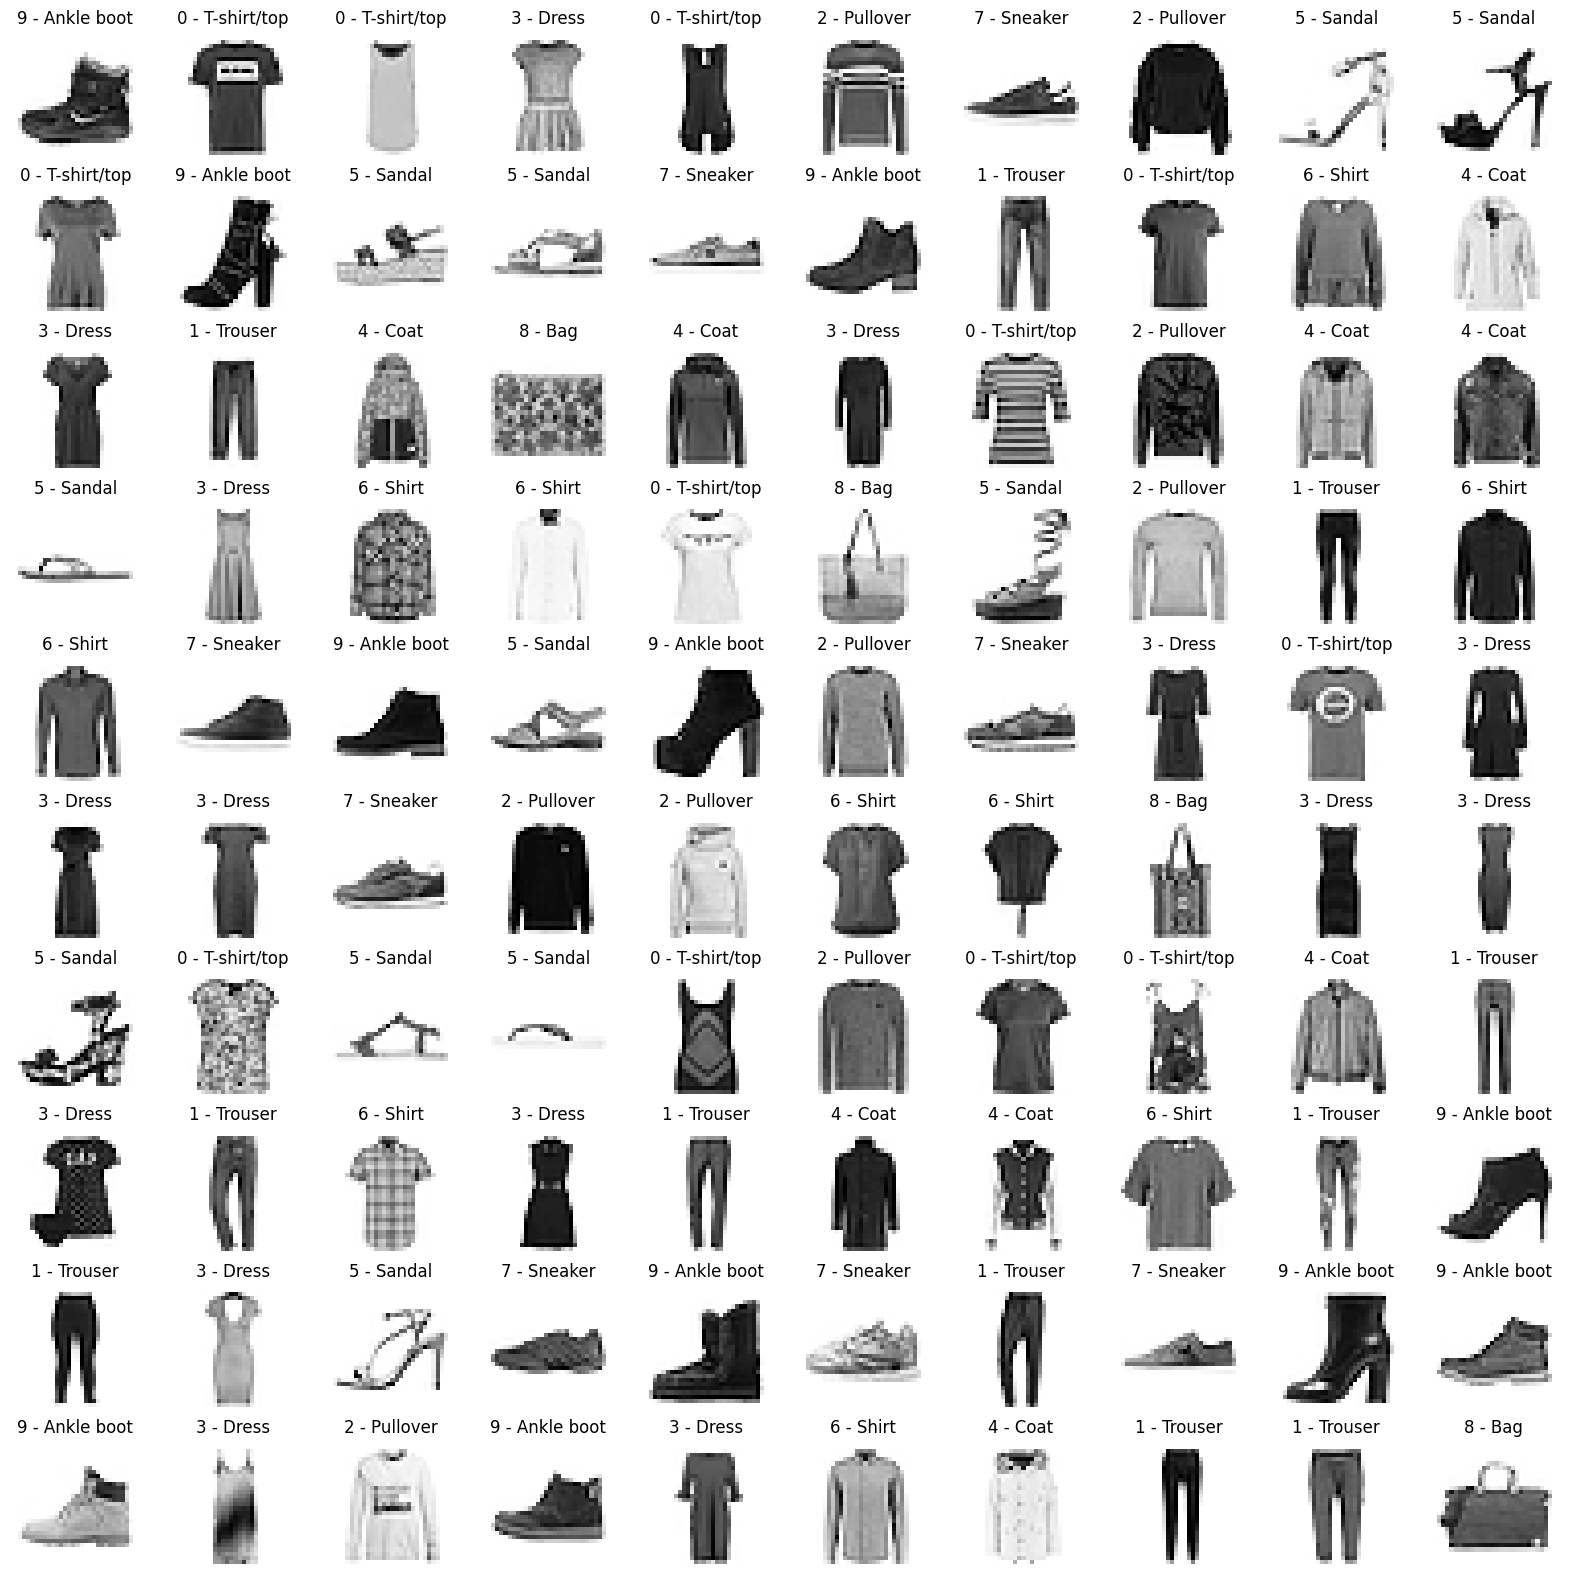

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))

for images, labels in DataLoader(train_loader.dataset, batch_size=100):
    print("Image batch shape:", images.shape)

    for i in range(100):
        plt.subplot(10, 10, i+1)

        image = images[i]
        image = np.transpose(image.numpy(), (1, 2, 0)) # (C,H,W) -> (H,W,C)
        label = labels[i]

        plt.imshow(image, cmap="Greys")
        plt.title(f"{label} - {train_dataset.classes[label]}")
        plt.axis("off")

    break

## Model

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.nn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.Flatten(),

            nn.Linear(128*4*4, self.latent_dim),
        )

    def forward(self, x):
        assert x.shape[2:] == (32, 32)

        x = self.nn(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.linear = nn.Linear(self.latent_dim, 128*4*4)
        self.reshape = lambda x: x.reshape(-1, 128, 4, 4)

        self.nn = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3,
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3,
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3,
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        assert x.shape[1:] == (self.latent_dim,)

        x = self.linear(x)
        x = self.reshape(x)
        x = self.nn(x)
        return x

class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def generate(self, x):
        assert x.shape[1:] == (self.latent_dim,)
        return self.decoder(x)

## Train

In [6]:
from tqdm import tqdm
from torchsummary import summary

model = AutoEncoder(latent_dim=2).to(DEVICE)
summary(model, (1,32,32))

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

def train():
    train_losses = []

    for images, _ in tqdm(train_loader, desc=f"epoch {epoch+1}", position=0, leave=False):
        images = images.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, images) # output should be the same as the input
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    test_losses = []

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            loss = loss_fn(outputs, images)
            test_losses.append(loss.item())

    return train_losses, test_losses

EPOCHS = 30
train_losses =[]
test_losses = []

for epoch in tqdm(range(EPOCHS), desc="total epoch", position=0):
    epoch_train_losses, epoch_test_losses = train()
    train_loss = np.mean(epoch_train_losses)
    test_loss = np.mean(epoch_test_losses)

    print(f"\n[epoch: {epoch+1}] train_loss: {train_loss}, test_loss: {test_loss}")

    train_losses.append(train_loss)
    test_losses.append(test_loss)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                    [-1, 2]           4,098
           Encoder-9                    [-1, 2]               0
           Linear-10                 [-1, 2048]           6,144
  ConvTranspose2d-11            [-1, 128, 8, 8]         147,584
             ReLU-12            [-1, 128, 8, 8]               0
  ConvTranspose2d-13           [-1, 64, 16, 16]          73,792
             ReLU-14           [-1, 64,

total epoch:   3%|▎         | 1/30 [00:17<08:39, 17.93s/it]


[epoch: 1] train_loss: 0.3758526421704535, test_loss: 0.28775079995393754


total epoch:   7%|▋         | 2/30 [00:35<08:20, 17.87s/it]


[epoch: 2] train_loss: 0.27496377669148525, test_loss: 0.27042873948812485


total epoch:  10%|█         | 3/30 [00:53<07:55, 17.62s/it]


[epoch: 3] train_loss: 0.26520787987668637, test_loss: 0.2641890347003937


total epoch:  13%|█▎        | 4/30 [01:10<07:34, 17.50s/it]


[epoch: 4] train_loss: 0.2606530873957327, test_loss: 0.26045082658529284


total epoch:  17%|█▋        | 5/30 [01:28<07:27, 17.89s/it]


[epoch: 5] train_loss: 0.2579755405500784, test_loss: 0.25816597044467926


total epoch:  20%|██        | 6/30 [01:47<07:10, 17.95s/it]


[epoch: 6] train_loss: 0.25650530245344516, test_loss: 0.2579123914241791


total epoch:  23%|██▎       | 7/30 [02:04<06:50, 17.84s/it]


[epoch: 7] train_loss: 0.25495202170085096, test_loss: 0.25822621285915376


total epoch:  27%|██▋       | 8/30 [02:22<06:29, 17.69s/it]


[epoch: 8] train_loss: 0.25405142026937616, test_loss: 0.25503172501921656


total epoch:  30%|███       | 9/30 [02:39<06:12, 17.73s/it]


[epoch: 9] train_loss: 0.25319620726977365, test_loss: 0.2546387180685997


total epoch:  33%|███▎      | 10/30 [02:57<05:56, 17.83s/it]


[epoch: 10] train_loss: 0.2523091613488682, test_loss: 0.25378475710749626


total epoch:  37%|███▋      | 11/30 [03:15<05:38, 17.83s/it]


[epoch: 11] train_loss: 0.252079949540607, test_loss: 0.25488112717866895


total epoch:  40%|████      | 12/30 [03:32<05:17, 17.63s/it]


[epoch: 12] train_loss: 0.2515941581736177, test_loss: 0.2533566437661648


total epoch:  43%|████▎     | 13/30 [03:50<05:00, 17.67s/it]


[epoch: 13] train_loss: 0.2506870840818195, test_loss: 0.25252204984426496


total epoch:  47%|████▋     | 14/30 [04:08<04:45, 17.82s/it]


[epoch: 14] train_loss: 0.2504242760902744, test_loss: 0.251840902119875


total epoch:  50%|█████     | 15/30 [04:26<04:28, 17.91s/it]


[epoch: 15] train_loss: 0.24990156103493805, test_loss: 0.25221006348729136


total epoch:  53%|█████▎    | 16/30 [04:44<04:08, 17.73s/it]


[epoch: 16] train_loss: 0.24967713439363545, test_loss: 0.2513668745756149


total epoch:  57%|█████▋    | 17/30 [05:01<03:48, 17.61s/it]


[epoch: 17] train_loss: 0.24928629802445235, test_loss: 0.2514288634061813


total epoch:  60%|██████    | 18/30 [05:19<03:31, 17.65s/it]


[epoch: 18] train_loss: 0.248984111315113, test_loss: 0.25094921290874483


total epoch:  63%|██████▎   | 19/30 [05:37<03:15, 17.76s/it]


[epoch: 19] train_loss: 0.24862054394463362, test_loss: 0.2508927911520004


total epoch:  67%|██████▋   | 20/30 [05:54<02:57, 17.71s/it]


[epoch: 20] train_loss: 0.24848464939553858, test_loss: 0.25039984807372095


total epoch:  70%|███████   | 21/30 [06:11<02:37, 17.51s/it]


[epoch: 21] train_loss: 0.24817086768857502, test_loss: 0.2503365263342857


total epoch:  73%|███████▎  | 22/30 [06:29<02:20, 17.60s/it]


[epoch: 22] train_loss: 0.24797482321322975, test_loss: 0.25041968151926997


total epoch:  77%|███████▋  | 23/30 [06:48<02:04, 17.80s/it]


[epoch: 23] train_loss: 0.24762869777820878, test_loss: 0.24973980262875556


total epoch:  80%|████████  | 24/30 [07:05<01:46, 17.79s/it]


[epoch: 24] train_loss: 0.24745428410627074, test_loss: 0.2508566930890083


total epoch:  83%|████████▎ | 25/30 [07:22<01:27, 17.60s/it]


[epoch: 25] train_loss: 0.2475766751725795, test_loss: 0.2495654746890068


total epoch:  87%|████████▋ | 26/30 [07:40<01:10, 17.64s/it]


[epoch: 26] train_loss: 0.2470016149898707, test_loss: 0.24952172860503197


total epoch:  90%|█████████ | 27/30 [07:57<00:52, 17.47s/it]


[epoch: 27] train_loss: 0.24687204067989932, test_loss: 0.24896660149097444


total epoch:  93%|█████████▎| 28/30 [08:15<00:35, 17.59s/it]


[epoch: 28] train_loss: 0.24667034866446155, test_loss: 0.24982496500015258


total epoch:  97%|█████████▋| 29/30 [08:33<00:17, 17.57s/it]


[epoch: 29] train_loss: 0.2464518923375566, test_loss: 0.24935507103800775


total epoch: 100%|██████████| 30/30 [08:50<00:00, 17.68s/it]


[epoch: 30] train_loss: 0.24658250644550486, test_loss: 0.24908049702644347


Text(0.5, 1.0, 'Loss')

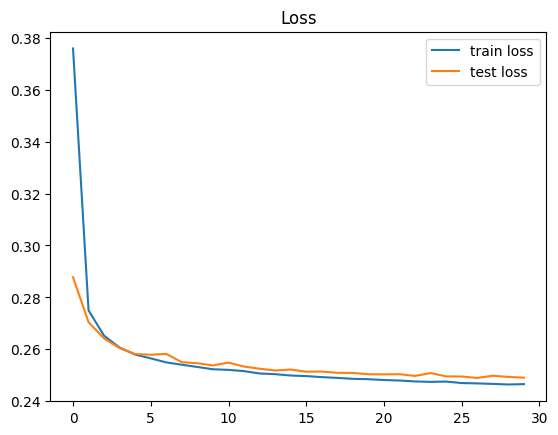

In [7]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.title("Loss")

## Result

### Comparison input images with output images

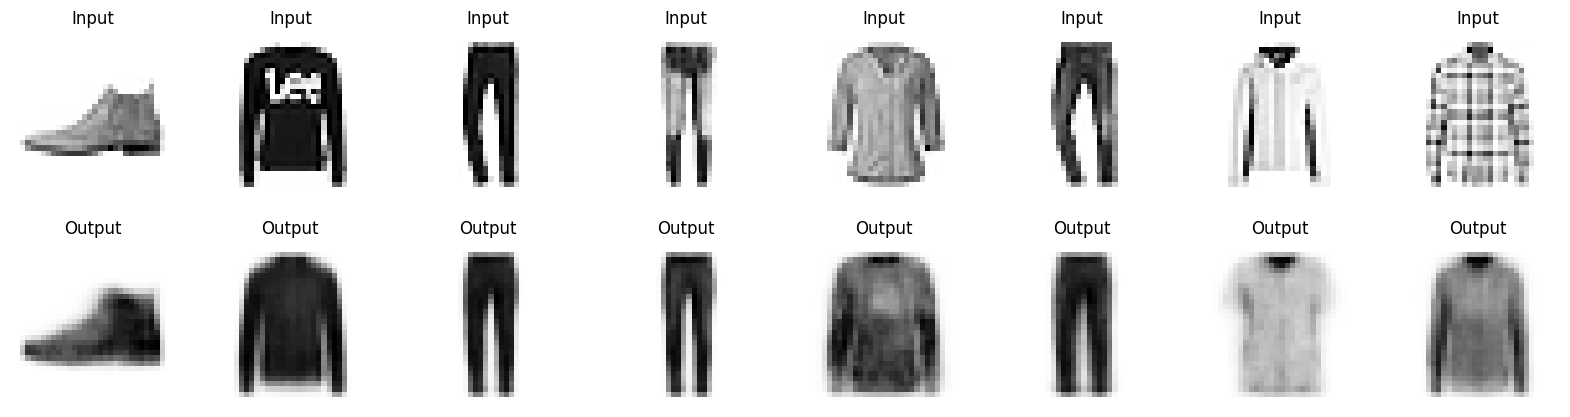

In [19]:
model.eval()

plt.figure(figsize=(20, 5))

i = 0
for images, labels in DataLoader(test_loader.dataset, batch_size=8):
    outputs = model(images.to(DEVICE))

    for image, label, output in zip(images, labels, outputs):
        plt.subplot(2, 8, i+1)
        plt.imshow(np.transpose(image, (1, 2, 0)), cmap="Greys")
        plt.title("Input")
        plt.axis("off")

        plt.subplot(2, 8, i+9)
        plt.imshow(np.transpose(output.cpu().detach(), (1, 2, 0)), cmap="Greys")
        plt.title("Output")
        plt.axis("off")
        i += 1

    break

### Latent Space

In [20]:
embeddings = np.empty((0, 2))
embedding_labels = np.array([], dtype=np.int8)

for images, labels in DataLoader(test_loader.dataset, batch_size=2):
    images = images.to(DEVICE)
    outputs = model.encoder(images)
    embeddings = np.concatenate([embeddings, outputs.cpu().detach()], axis=0)
    embedding_labels = np.append(embedding_labels, labels.numpy())

embeddings.shape, embedding_labels.shape

((10000, 2), (10000,))

Text(0.5, 1.0, 'AutoEncoder latent space')

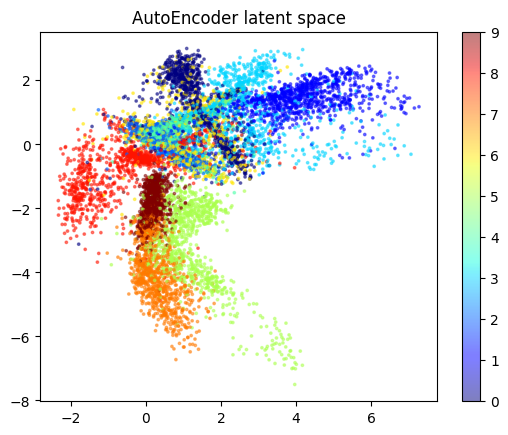

In [21]:
plt.scatter(embeddings[:, 0], embeddings[:, 1],
            c=embedding_labels, cmap="jet",
            alpha=0.5, s=3)
plt.colorbar()
plt.title("AutoEncoder latent space")

## Image Generation

In [22]:
sample_embeddings = np.random.uniform(
    np.min(embeddings, axis=0),
    np.max(embeddings, axis=0),
    size=(100, 2)
)

sample_outputs = model.decoder(torch.Tensor(sample_embeddings).to(DEVICE))
sample_outputs = sample_outputs.cpu().detach().numpy()
sample_outputs.shape

(100, 1, 32, 32)

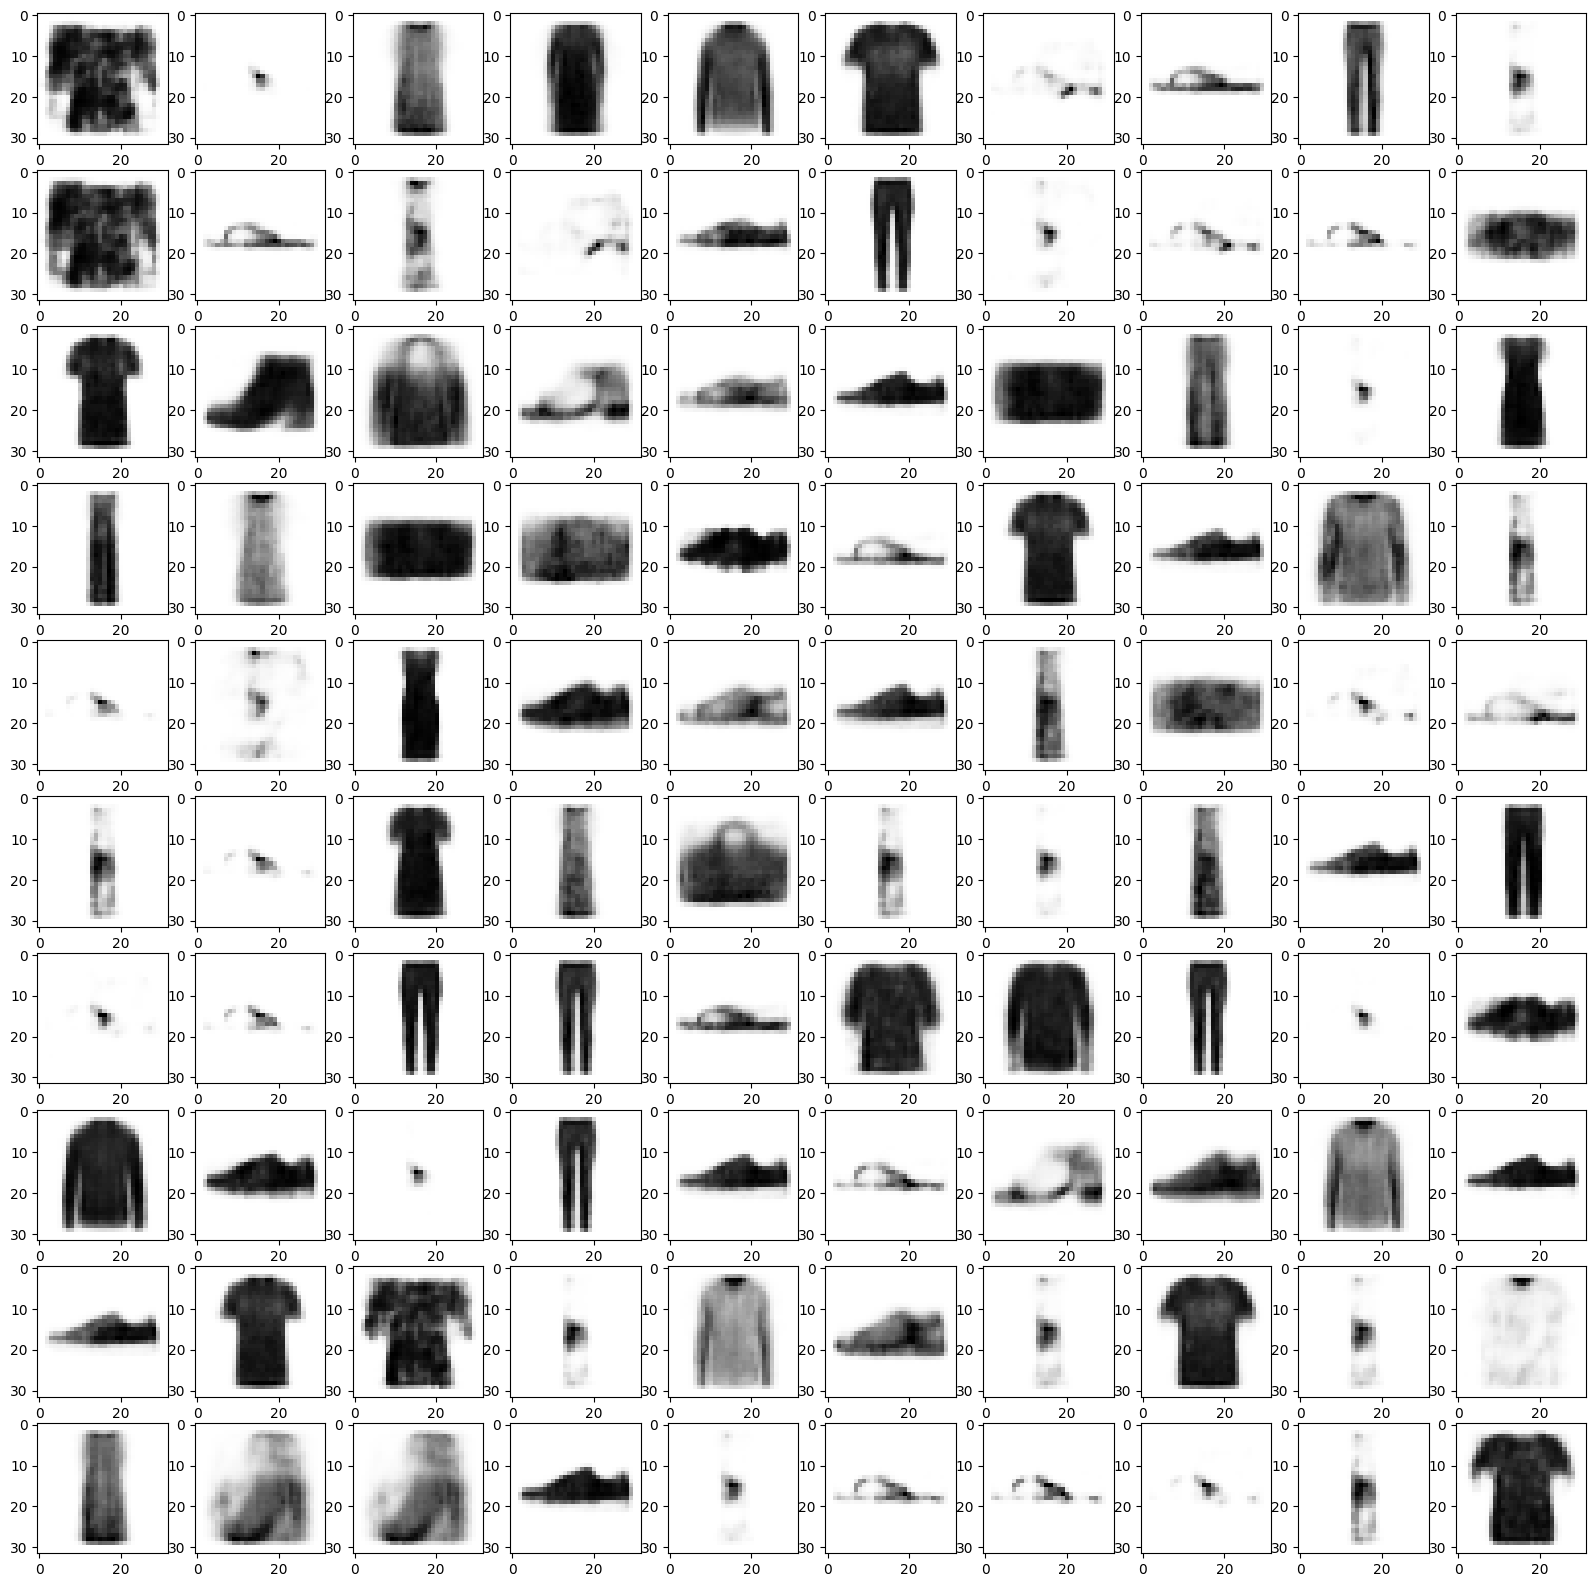

In [23]:
plt.figure(figsize=(20, 20))

for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(
        np.transpose(sample_outputs[i], (1, 2, 0)), # (C,H,W) -> (H,W,C)
        cmap="Greys"
    )